In [20]:
import cv2
import numpy as np
from glob import glob
import os
import tifffile as tiff # for reading .TIFF files
import glymur as glm # for reading .JP2 files (needs openjpeg)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_folders = glob('data' + os.sep + '*')

Here we will begin by analyzing images captured by the SAR (Synthetic Aperture Radar) satellites. The SAR data presented herein contains images taken in 2 polarization modes - 

1. VV - Vertical Transmit, Vertical Receive : Same polarization like this can help distinguish same surfaces having different states (like capillary waves in water bodies)

2. VH - Vertical Transmit, Horizontal Receive : Cross-polarisation like this is useful when volume (multiple) scattering occurs. It can allow the separation of soil and vegetation and of forest and non-forest.

Here, we will try to utilize their natures to find water body masks from the radar images.

In [4]:
# ---------------------SAR (Synthetic Aperture Radar) PROCESSING--------------------- #

sentinel_1_SAR_folders = [d for d in data_folders if 'S1' in d]

s1a_201808_folder = [f for f in sentinel_1_SAR_folders if '201808' in f][0]
s1a_201809_folder = [f for f in sentinel_1_SAR_folders if '201809' in f][0]

Analyzing SAR images from 08/2018-

In [8]:
# Performs exploratory data analysis by performing image addition,
# subtraction, & multiplication. Only useful for observing patterns
# manually and making algorithms.
def sar_image_analyze_explore(sar_folder_path,
                              create_split_viz=False,
                              reorient=True,
                              bypass_ops=False):
    img_list_suffix = 'measurement' + os.sep + '*.tiff'

    img_paths = glob(sar_folder_path + os.sep + img_list_suffix)

    if create_split_viz: #creates chunked viewable 8-bit histogram normalized images for human viewing;
        for img_path in img_paths:
            preprocess_images(img_path)

    vh_path = [p for p in img_paths if '-vh-' in p][0]
    vv_path = [p for p in img_paths if '-vv-' in p][0]

    im_vh = tiff.imread(vh_path)
    im_vv = tiff.imread(vv_path)

    out_dir = sar_folder_path.split(os.sep)[-1] + '_analysis'
    force_makedir(out_dir)

    if reorient: #original images are north-south flipped, this corrects it
        im_vh = np.flipud(im_vh)
        im_vv = np.flipud(im_vv)
        tiff.imsave(open(vh_path.replace('.tiff', '_reoriented.tiff'), 'wb'), im_vh)
        tiff.imsave(open(vv_path.replace('.tiff', '_reoriented.tiff'), 'wb'), im_vv)

    if not bypass_ops:

        vh_vv_diff = cv2.subtract(im_vh, im_vv)
        vv_vh_diff = cv2.subtract(im_vv, im_vh)

        vhvv_diff_path = out_dir + os.sep + 'vh_vv_diff.tiff'
        vvvh_diff_path = out_dir + os.sep + 'vv_vh_diff.tiff'

        tiff.imsave(open(vhvv_diff_path, 'wb'), vh_vv_diff)
        tiff.imsave(open(vvvh_diff_path, 'wb'), vv_vh_diff)

        vh_vv_add = cv2.add(im_vh, im_vv)
        vh_vv_mul = cv2.multiply(im_vh, im_vv)

        vhvv_add_path = out_dir + os.sep + 'vh_vv_add.tiff'
        vhvv_mul_path = out_dir + os.sep + 'vh_vv_mul.tiff'

        tiff.imsave(open(vhvv_add_path, 'wb'), vh_vv_add)
        tiff.imsave(open(vhvv_mul_path, 'wb'), vh_vv_mul)

    return im_vh, im_vv, out_dir

def force_makedir(dir):
    if not os.path.isdir(dir):
        os.makedirs(dir)

In [9]:
sar_folder_path = s1a_201808_folder

# Simply reading the tiff files
im_vh, im_vv, out_dir = sar_image_analyze_explore(sar_folder_path,
                                                  create_split_viz=False,
                                                  reorient=True,
                                                  bypass_ops=True)

Water bodies are very reflective surfaces. They tend to completely reflect all the radar energy away from them at an angle equal to the incidence anglemaking them appear dark in both VH & VV images. The same applies to smooth surfaces like runways etc.

Here, we will be highlighting water bodies and airport runway stretches which is otherwise, less observed in the original radar images. 

We shall do this by multiplying the VH & VV images and thresholding the resulting image at the mean - standard_deviation of all of its pixels.

After performing some cleaning an dpost-processing on this image, the water bodies become apparent.

In [10]:
def find_waterish_surface_mask(im_vh, im_vv):
    vh_vv_mul = cv2.multiply(im_vh, im_vv)
    m = vh_vv_mul.max()
    vh_vv_mul[vh_vv_mul > (vh_vv_mul.mean() - vh_vv_mul.std())] = 0
    vh_vv_mul[vh_vv_mul > 0] = m
    return vh_vv_mul

In [11]:
waterish_mask_raw = find_waterish_surface_mask(im_vh, im_vv)

#Saving the 16-bit image
tiff.imsave(open(out_dir + os.sep + 'waterish_mask_raw.tiff', 'wb'), waterish_mask_raw)

In [13]:
watermask_viz = waterish_mask_raw.copy()
watermask_viz[watermask_viz > 0] = 255
watermask_viz = watermask_viz.astype(np.uint8)

Original shape = (16685, 26545)
Scaled down shape = (1668, 2654)


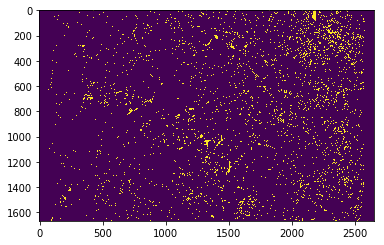

In [29]:
print('Original shape =', watermask_viz.shape)
h, w = watermask_viz.shape
viz = cv2.resize(watermask_viz, (int(w * .1), int(h * .1)), interpolation=cv2.INTER_NEAREST)
print('Scaled down shape =', viz.shape)
plt.imshow(viz)
plt.show()

This image doesn't visually reveal too much as there is significant downsampling happening over here (more than 90% of the pixels are lost). Therefore, screenshots of the results will be shown for better visibility.

Now we shall clean this image of noisy spots with the following method -

In [30]:
def sar_water_mask_postprocess(waterish_mask_raw, out_dir):
    # Performing Dilation followed by Erosion
    waterish_mask_raw_morphclosed = cv2.morphologyEx(waterish_mask_raw, cv2.MORPH_CLOSE,
                                                    cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_morphclosed.tiff', 'wb'), waterish_mask_raw_morphclosed)
    
    # Performing Erosion followed by Dilation
    waterish_mask_raw_morphclosed_morphopened = cv2.morphologyEx(waterish_mask_raw_morphclosed, cv2.MORPH_OPEN,
                                                                cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
                                                                iterations=1)
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_morphclosed_morphopened.tiff', 'wb'),
                waterish_mask_raw_morphclosed_morphopened)
    
    # Filtering out small speckles (blobs whose area is lesser than mean blob area
    # are removed)
    _, polys, _ = cv2.findContours(waterish_mask_raw_morphclosed_morphopened.astype(np.uint8),
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    poly_areas = np.array([cv2.contourArea(poly) for poly in polys])
    polys_mask = poly_areas > poly_areas.mean()
    chosen_polys = np.array(polys)[polys_mask]
    waterish_mask_raw_morphclosed_morphopened_polycleaned = np.zeros_like(waterish_mask_raw_morphclosed_morphopened)
    cv2.drawContours(waterish_mask_raw_morphclosed_morphopened_polycleaned, chosen_polys, -1,
                     65535, -1)
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_morphclosed_morphopened_polycleaned.tiff', 'wb'),
                waterish_mask_raw_morphclosed_morphopened_polycleaned)

    return waterish_mask_raw_morphclosed_morphopened_polycleaned

In [31]:
waterish_mask_postprocessed = sar_water_mask_postprocess(waterish_mask_raw, out_dir)

In [33]:
def u16_to_u8(im):
    a = (im / 65535) * 255
    a = a.astype(np.uint8)
    return a

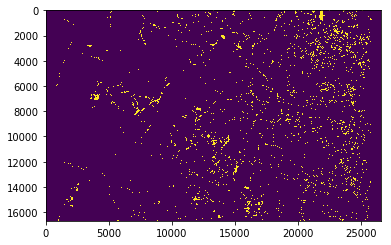

In [34]:
viz = u16_to_u8(waterish_mask_postprocessed)
plt.imshow(viz)
plt.show()

A side-by-side baked visualization of the results is shown below-

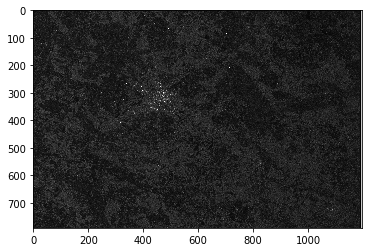

In [36]:
im = cv2.imread('s1a_comparison_org.png')
plt.imshow(im)
plt.show()

This is the original image

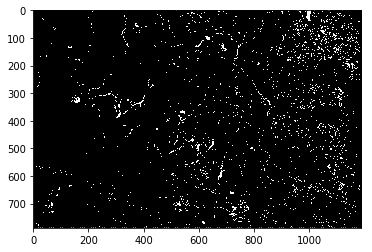

In [37]:
im = cv2.imread('s1a_comparison_watermask.png')
plt.imshow(im)
plt.show()

This is the watermask extracted. Although there isn't too much of a quality improvement, it is more visible. For better comparison, please see the files 's1a_comparison_org.png' and 's1a_comparison_watermask.png' representing the original and the watermask extracted images respectively.

Now we shall process the other radar image from 09/2018-

In [38]:
# Putting all the above methods in to one function

def sar_image_process(sar_folder_path, create_split_viz=False, reorient=True, bypass_exploration=False):
    im_vh, im_vv, out_dir = sar_image_analyze_explore(sar_folder_path,
                                                      create_split_viz=create_split_viz,
                                                      reorient=reorient,
                                                      bypass_ops=bypass_exploration)
    waterish_mask_raw = find_waterish_surface_mask(im_vh, im_vv)
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_raw.tiff', 'wb'), waterish_mask_raw)

    waterish_mask_postprocessed = sar_water_mask_postprocess(waterish_mask_raw, out_dir)

    return waterish_mask_postprocessed

In [39]:
water_mask_201809 = sar_image_process(s1a_201809_folder, create_split_viz=False,
                                      reorient=True, bypass_exploration=True)

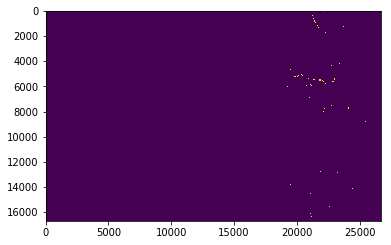

In [40]:
viz = u16_to_u8(water_mask_201809)
plt.imshow(viz)
plt.show()

As this again doesn't reveal much visually, the baked results are presented below -

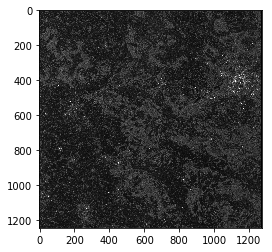

In [41]:
im = cv2.imread('s1b_comparison_org.png')
plt.imshow(im)
plt.show()

This is the original image

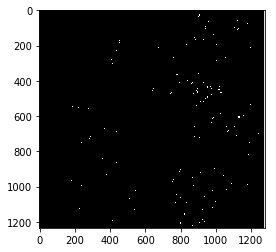

In [42]:
im = cv2.imread('s1b_comparison_watermask.png')
plt.imshow(im)
plt.show()

This image is quite sparse in terms of water bodies so its even less evident on the notebook. However, the corresponding file visualizations can be viewed in 's1b_comparison_org.png' and 's1b_comparison_watermask.png' for original and watermask images respectively.